# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

## Definizione delle costanti utilizzate

Le seguenti costanti sono quelle che mi hanno permesso di ottenere risultati migliori durante il training.



In [1]:
INPUT_SHAPE = (32,32,3)
KERNEL_SIZE = (3,3)
ACTIVATION = 'relu'
BATCH_SIZE = 32
VALIDATION_SIZE = 10000
EPOCHS = 200
STEPS = 1500
DECAY_STEPS = int(0.01 * STEPS * EPOCHS)
DECAY_RATE = 0.96
POOL_SIZE = (2,2)
LEARNING_RATE = 0.001

##Preparazione dei dati

In [2]:
import tensorflow as tf
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


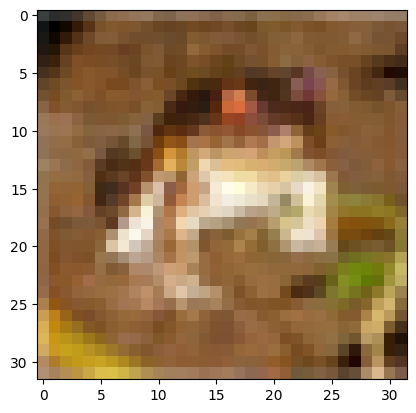

In [3]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.imshow(cifar10_x_train[0])
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [4]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

La modifica della riga
```
y_data = [Y1_cat[num1],Y2_cat[num2]]
```
in
```
y_data = (Y1_cat[num1],Y2_cat[num2])
```
si è resa necessaria per poter passare un'istanza del generatore direttamente al metodo *fit* di Keras. Altrimenti si otteneva un TypeError.


In [5]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


##Data augmentation
L'utilizzo a inizio dell'architettura del layer *RandomFlip* ha portato a
una leggera diminuzione dell'overfitting. Questo layer esegue un flip orizzontale delle immagini con cadenza casuale, questo ha permesso al modello di migliorare la propria capacità di generalizzazione.

##Architettura del modello

Per questa task di image classification ho optato per concentrare quasi tutti i
parametri del modello su blocchi convolutivi al fine di massimizzare la
feature extraction.
La funzione *residual_block(filters, input, downsize=False)* implementa un blocco con 2 convoluzioni con il medesimo numero di filtri, ai quali ho aggiunto una skip connection che ha consentito di poter aggiungere più blocchi convoluzionali consecutivi. Il design del blocco residuale è ispirato a quello proposto nella rete ResNet.
Per stabilizzare il processo di backpropagation, nei livelli convolutivi, prima di chiamare la funzione di attivazione introduco un layer di normalizzazione
che ha il compito di avvicinare la media dei valori a 0 e la loro deviazione standard a 1.

Il downsampling viene eseguito tramite convoluzioni con stride 2, ed è regolato tramite la variabile booleana *downsize*.

Al termine di ogni blocco convoluzionale introduco un layer di Dropout con dropout rate pari a 0.15, ciò ha permesso di mitigare l'overfitting durante il training.

La prima parte della convoluzione è unica ed è costituita da un layer convolutivo a 32 filtri e kernel size pari a 5. Questo layer è stato introdotto per ottenere una migliore estrazione delle feature ad alto livello.
In seguito inizia la sequenza di blocchi residuali, 2 da 32 filtri, 2 da 64 filtri. A questo punto eseguo un branching della rete in due rami, per ciascun ramo introduco due blochi da 128 filtri per consentire un'estrazione profonda e specifica delle feature che distinguono i due gruppi di classi.
I due rami sono simmetrici e terminano con un global average pooling layer che consente di ridurre il tensore in input ad un tensore monodimensionale con lunghezza pari al numero di canali (128 nel mio caso).
Questi layer favoriscono le task di classificazione per immagini e sono seguiti da due layer densi con 32 neuroni che precedono i due livelli finali di output, questi due layer  usano softmax come funzione di attivazione (tutti gli altri usano relu), in quanto il modello deve eseguire una doppia classificazione contemporaneamente.


In [6]:
#model architecture
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Add, RandomFlip, Activation, GlobalAveragePooling2D

def residual_block(filters, input, downsize=False):
  shortcut = input

  #first convolutional layer
  if downsize:
    x = Conv2D(filters, kernel_size=KERNEL_SIZE, padding="same", strides=2, data_format="channels_last")(input)
    shortcut = Conv2D(filters, kernel_size=(1,1), strides=2, activation=None, padding="same", data_format="channels_last")(shortcut)
    shortcut = BatchNormalization()(shortcut)
  else:
   x = Conv2D(filters, kernel_size=KERNEL_SIZE, padding="same", data_format="channels_last")(input)
  x = BatchNormalization()(x)
  x = Activation(ACTIVATION)(x)

  # second concolutional layer
  x = Conv2D(filters, kernel_size=KERNEL_SIZE, padding="same", data_format="channels_last")(x)
  x = BatchNormalization()(x)


  #skip connection
  x = Add()([x, shortcut])
  x = Activation(ACTIVATION)(x)
  x = Dropout(0.15)(x)
  return x

def model():
  #input layer
  input = Input(shape=INPUT_SHAPE, dtype="float32")
  #data augmentation
  x = RandomFlip(mode="horizontal")(input)

  #convolutional part of the net
  x = Conv2D(32, kernel_size=(5,5), padding="same", data_format="channels_last")(x)
  x = BatchNormalization()(x)
  x = Activation(ACTIVATION)(x)
  x = residual_block(32, x)
  x = residual_block(32, x)
  x = residual_block(64, x, downsize=True)
  x = residual_block(64, x)
  #separation of convolutional blocks (branching)
  x1 = residual_block(128, x, downsize=True)
  x1 = residual_block(128, x1)
  x2 = residual_block(128, x, downsize=True)
  x2 = residual_block(128, x2)

  #GAP
  x1 = GlobalAveragePooling2D()(x1)
  x2 = GlobalAveragePooling2D()(x2)

  #dense layers
  x1 = Dense(32, activation=ACTIVATION)(x1)
  x1 = Dropout(0.15)(x1)
  x2 = Dense(32, activation=ACTIVATION)(x2)
  x2 = Dropout(0.15)(x2)

  #output layers
  output1 = Dense(5, activation="softmax", name="output_1")(x1)
  output2 = Dense(5, activation="softmax", name="output_2")(x2)
  return Model(input, [output1, output2])


##Training

Per il training ho scelto Adam come optimizer, associato a uno scheduler del
learning rate che decrementa il learning rate con una funzione esponenziale.
I parametri costanti passati allo scheduler sono quelli che mi hanno permesso
di ottenere i migliori risultati e sono il frutto di un processo di verifica e
testing iterativo.

In [7]:
import keras
from keras.optimizers.schedules import ExponentialDecay

#learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE
)

#optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model = model()

model.compile(
    optimizer=optimizer,
    loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
    metrics={'output_1': 'accuracy', 'output_2': 'accuracy'}
  )
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │          2,432 │ random_flip[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 32)     │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ activation_3[0][0]     │
├──────────────────────

 Total params: 1,236,298 (4.72 MB)

 Trainable params: 1,232,778 (4.70 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [8]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2, BATCH_SIZE)
validationgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2, VALIDATION_SIZE)

x, y = next(validationgen)
test_inputs = x
test_labels1 = y[0]
test_labels2 = y[1]

history = model.fit(
    x=datagen,
    validation_data=(test_inputs, {'output_1': test_labels1, 'output_2': test_labels2}),  # Validation data
    steps_per_epoch=STEPS,  # Number of batches per epoch
    epochs=EPOCHS  # Number of epochs
)



Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 2.8236 - output_1_accuracy: 0.3825 - output_1_loss: 1.4304 - output_2_accuracy: 0.4076 - output_2_loss: 1.3933 - val_loss: 2.7957 - val_output_1_accuracy: 0.4523 - val_output_1_loss: 1.3356 - val_output_2_accuracy: 0.4165 - val_output_2_loss: 1.4608
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 2.3729 - output_1_accuracy: 0.4757 - output_1_loss: 1.2679 - output_2_accuracy: 0.5722 - output_2_loss: 1.1050 - val_loss: 3.1507 - val_output_1_accuracy: 0.4343 - val_output_1_loss: 1.5643 - val_output_2_accuracy: 0.4632 - val_output_2_loss: 1.5865
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 2.1571 - output_1_accuracy: 0.5141 - output_1_loss: 1.1842 - output_2_accuracy: 0.6281 - output_2_loss: 0.9728 - val_loss: 2.0463 - val_output_1_accuracy: 0.5358 - val_output_1_loss: 1.1506 - val_output_2_accuracy: 0.6545 - val_output_2_loss: 0.8961
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/ste

##Visualizzazione dei risultati

I seguenti grafici riportano una visualizzazione dell'andamento di loss, accuracy durante il training, per entrambi i gruppi di classi.

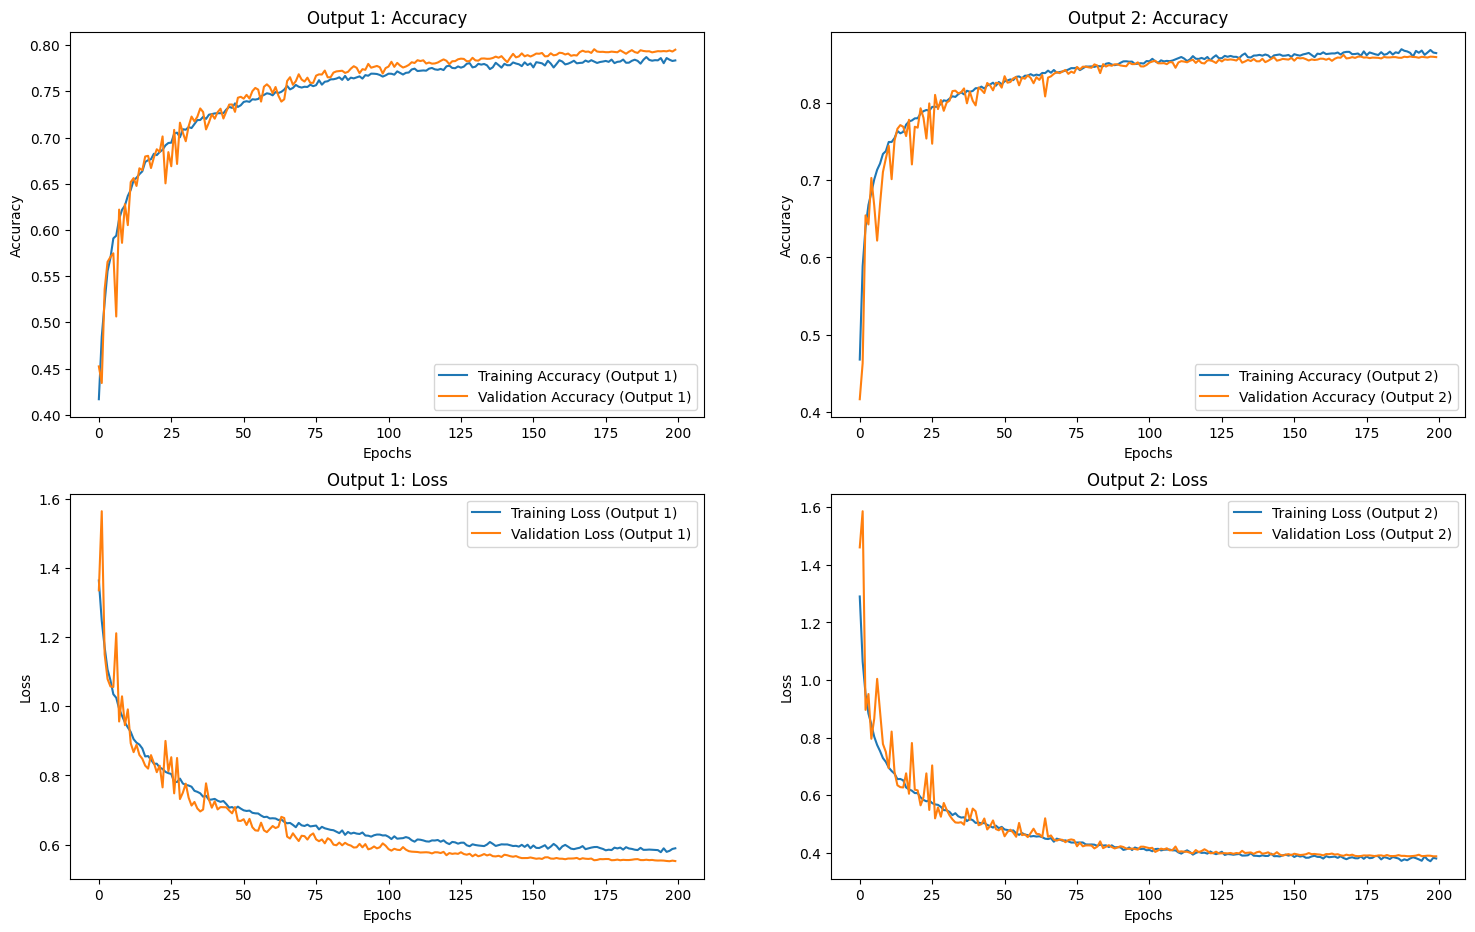

In [9]:
# Access the history data
history_dict = history.history

# Plot training and validation accuracy for each output
plt.figure(figsize=(18, 11))

# Plot accuracy for output1
plt.subplot(2, 2, 1)
plt.plot(history_dict['output_1_accuracy'], label='Training Accuracy (Output 1)')
plt.plot(history_dict['val_output_1_accuracy'], label='Validation Accuracy (Output 1)')
plt.title('Output 1: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot accuracy for output2
plt.subplot(2, 2, 2)
plt.plot(history_dict['output_2_accuracy'], label='Training Accuracy (Output 2)')
plt.plot(history_dict['val_output_2_accuracy'], label='Validation Accuracy (Output 2)')
plt.title('Output 2: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss for output1
plt.subplot(2, 2, 3)
plt.plot(history_dict['output_1_loss'], label='Training Loss (Output 1)')
plt.plot(history_dict['val_output_1_loss'], label='Validation Loss (Output 1)')
plt.title('Output 1: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot loss for output2
plt.subplot(2, 2, 4)
plt.plot(history_dict['output_2_loss'], label='Training Loss (Output 2)')
plt.plot(history_dict['val_output_2_loss'], label='Validation Loss (Output 2)')
plt.title('Output 2: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [14]:
model.save_weights("model.weights.h5")

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: bird, second = dog


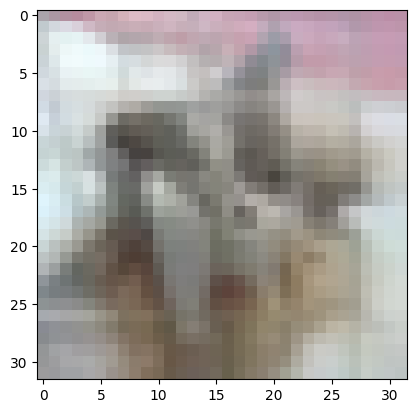

In [ ]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.imshow(x[0])

# Valutazione

Definiamo innanzi tutto il generatore di testing.

In [10]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


In [11]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  model_output = model.predict(eval_samples_x)
  model_output = np.array(model_output)
  eval_samples_y = np.array(eval_samples_y)

  correct_guesses_1 = np.argmax(model_output[0],axis=1) == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = np.argmax(model_output[1],axis=1) == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

let us repeat the evaluation ten times, and comput the standard deviation

In [20]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mean accuracy =  0.8274950000000001
standard deviation =  0.0027563971049179617


# Cosa consegnare

Come di consueto, dovete consegnare un singolo notebook che deve essere eseguibile su colab. Il notebook deve essere adeguatamente commentato a contenere una traccia completa del training, come anche il calcolo della accuratezza secondo le direttive date sopra.

#Buon lavoro!